In [ ]:
%load_ext autoreload
%autoreload 2

# Intro

Welcome to the BlendingToolKit (BTK) quickstart! This tutorial will guide you through the basic functionalities of BTK. If you are new to BTK, we recommend you to go through this notebook before moving on to the other tutorials.

We will show you how to generate a catalog of galaxy blends, draw images of these blends, use algorithms implemented within BTK to deblend these images, and finally use metrics within BTK to assess the performance of the deblender.

# Setup

First, we will need to import the relevant python packages and modules:

In [ ]:
%matplotlib inline
import numpy as np
import os

In [ ]:
import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions

# Drawing Blends

Before generating images of blends, we require some setup. 

**First**, we need to specify a catalog of galaxies to draw. We will use a subset of the CATSIM catalog, which contains `100` galaxies with realistic parameters.

BTK uses a wrapper class (e.g. `btk.catalog.CatsimCatalog`) to store information about the galaxy catalog you pass in. You can easily import the CATSIM catalog from a FITS file using the `from_file` method as demonstrated here with our example catalog:

In [ ]:
catalog_name = "../data/sample_input_catalog.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
catalog.table[:5] # display 5 first entries of table containing the actual catalog information.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,1505.9509277292,-0.5342399817876,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969,23.3607368469,1.29850754499422
2205921112,1512.1024131744,-3.609359823168,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163,25.9851398468,1.6685768318179002
2205010878,1524.3564605652,-11.266919877384,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995,25.6957893372,2.07034437656444
2208734677,1515.910291668,-0.26135999942183996,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883,26.6737632751,1.45789307534616
2212241881,1523.4518051136,-7.851959858088,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602,27.0680370331,1.93071491420404


**Second**, we require specifying a *sampling function*. The sampling function is a custom class within BTK that is used to determine which galaxies are drawn for each blend and what their locations within the blend should be. 

Specifically, we implement this functionality with the `SamplingFunction` class, which is a `callable` like a function. It takes as argument the astropy table contained within the `Catalog` object above, selects galaxies to be drawn in a given blend, and returns their (possibly modified) entries. Usually the `ra` and `dec` columns of these entries are modified to be relative to the center of the postage stamp containing the blend. 

For this tutorial, we will use the *default sampling function*, this function is implemented in the `btk.sampling_functions` module and is called `DefaultSampling`. This function draws a random number of galaxies from the catalog, uniformly distributed between 1 and `max_number`, and places them randomly within the postage stamp with some maximum shift `max_shift` w.r.t the center of the postage stamp.

The `DefaultSampling` function can be instantiated as follows:

In [ ]:
stamp_size = 24.0  # Size of the stamp, in arcseconds
max_number = 3     # Maximum number of galaxies in a blend
max_shift = 3.0    # Maximum shift of the galaxies, in arcseconds
seed = 1 # random seed for reproducibility purposes
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, stamp_size=stamp_size, max_shift=max_shift, seed = seed)

Here is an example output of the `DefaultSampling` function:

In [ ]:
blend_catalog = sampling_function(catalog.table)
blend_catalog # ra and dec are now relative to the center of the blend (not the original ones)

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2202277660,-2.135042323682198,-1.1290112879370873,1.1246805191,6.15615677509e-19,1.09819897835e-17,0.0,0.130108296871,2.49873948097,0.0865847021341,2.48218655586,89.9871063232,89.9871063232,30.0631866455,27.7341003418,25.7658348083,24.6860561371,23.8522891998,23.3242969513,24.6860561371,11.330954289694109
2200002241,2.6918966828234634,-0.4600413061645461,0.286700099707,5.92275188752e-16,2.6139930149e-15,0.0,0.72993272543,2.83298206329,0.723316073418,0.934578001499,179.033691406,179.033691406,20.3450546265,19.2668266296,18.2675285339,17.8270835876,17.5972328186,17.4129009247,17.8270835876,11.92895522428243


**Third**, we need to specify a *survey*. This will determine the pixel scale, sky level, and PSF of the images we will draw. 

BTK relies on the [galcheat](https://github.com/aboucaud/galcheat) package, which contains several `galcheat.survey.Survey` instances, which store the parameters for different surveys (including LSST, HSC, HST COSMOS...). The parameters represent physical parameters of the survey (mirror size, pixel scale). Each survey also contains several `galcheat.filter.Filter` objects with the parameters specific to each filter (exposure time, zeropoint). 

In BTK, we use the `btk.survey.Survey` class to store the survey parameters. This class is a simple wrapper around the `galcheat.survey.Survey` class, and contains additional information such as the PSF model.

For this tutorial, we will import the survey corresponding to LSST.

In [ ]:
LSST = btk.survey.get_surveys("LSST")

You can see the parameters of the survey by printing the `Survey` object:

In [ ]:
print(LSST)

--------
| LSST | Legacy Survey of Space and Time (LSST) done with the Simonyi survey telescope and the LSST camera
--------
  pixel_scale          = 0.2 arcsec
  mirror_diameter      = 8.36 m
  gain                 = 1.0 electron / adu
  obscuration          = 0.39257227
  zeropoint_airmass    = 1.2
  available_filters    = ['u', 'g', 'r', 'i', 'z', 'y']
  effective_area       = 33.342414830068996 m2


**Finally**, now that we have finished our setup, we can create the `DrawBlendsGenerator`. This object is a python `generator`, meaning it can be called with `next(generator)` to generate a new batch of blend catalogs and images. 

The `DrawBlendsGenerator` takes as arguments the `Catalog` object, the `SamplingFunction` object, and the `Survey` object. It also takes a few other arguments, such as the number of images to draw per batch, the size of the postage stamps, and the number of galaxies to draw per blend.

In [ ]:
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=100,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

The output of the `DrawBlendsGenerator` is a class called `BlendBatch`, which contains the truth catalogs, simulated blends, and isolated images (among other metadata). 

For example to access the images of blends, we can use the following syntax:

In [ ]:
blend_batch.blend_images.shape 
# shape = (batch_size, n_bands, stamp_size, stamp_size)

(100, 6, 120, 120)

The truth catalogs are contained in the `catalog_list` object which is a list of catalogs, one per each blend in the batch. In total there are `batch_size` blends in the batch.

In [ ]:
blend_batch.catalog_list[0] 
# blend_list is a list of astropy tables, one for each blend in the batch.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size,x_peak,y_peak,btk_rotation,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200813818,0.29756212603835674,0.2288598793156691,0.350970596075,0.0,3.65527208395e-17,0.0,0.0,0.273549705744,0.0,0.0649354979396,0.0,71.0713500977,24.9696521759,24.2869358063,23.410484314,23.070728302,22.8698596954,22.7205543518,23.070728302,1.2747416287670401,60.98781063044967,60.644299396556384,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2202484794,-2.83464532054159,-1.021609701005447,0.737505495548,0.0,6.11022188471e-18,0.0,0.0,0.403777301311,0.0,0.195289194584,0.0,232.21925354,26.6245307922,26.2098960876,25.5539073944,24.7192592621,24.4865779877,24.3074092865,24.7192592621,1.88160222410926,45.3267733962554,54.39195149443184,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200813818,1.521078652048839,1.7305722205704264,0.350970596075,0.0,3.65527208395e-17,0.0,0.0,0.273549705744,0.0,0.0649354979396,0.0,71.0713500977,24.9696521759,24.2869358063,23.410484314,23.070728302,22.8698596954,22.7205543518,23.070728302,1.2747416287670401,67.10539326039019,68.15286110313546,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is also additional information which you can inspect by printing the `BlendBatch` object. Specifically, the PSF and WCS. The PSF is a list of `galsim.GSObject` objects, one per filter, and the WCS is an astropy `WCS` object.

In [ ]:
blend_batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 120, 120]
	 isolated_images: np.ndarray, shape [100, 3, 6, 120, 120]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

We can proceed to display a given blend using `matplotlib`:

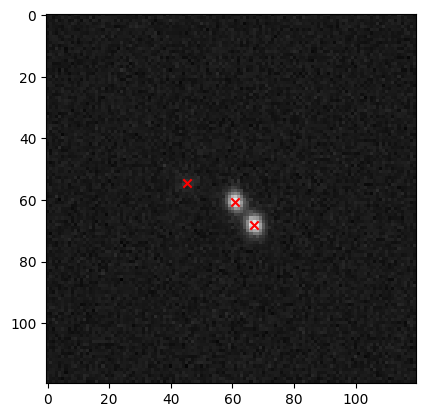

In [ ]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[0, 2, :, :], cmap="gray")

# plot centers
plt.scatter(blend_batch.catalog_list[0]["x_peak"], blend_batch.catalog_list[0]["y_peak"], c="r", marker="x")

We can use the function from `astropy` to plot in RGB (see [documentation](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html) here for more info):

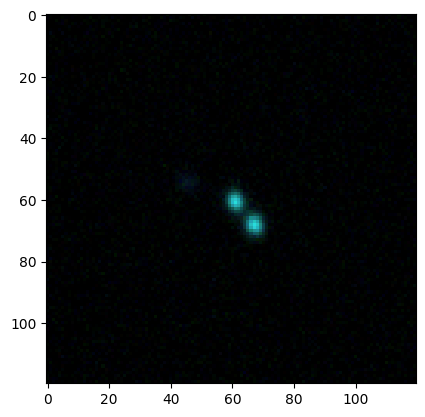

In [ ]:
from astropy.visualization import make_lupton_rgb

im = blend_batch.blend_images[0]
bands = [1, 2, 3] # g, r, i 
stretch = np.max(im) - np.min(im)
Q = 0.1

img_rgb = make_lupton_rgb(im[bands[0]], im[bands[1]], im[bands[2]], stretch=stretch, Q=Q)
plt.imshow(img_rgb)

Or our own BTK utility function which uses a linear stretch:

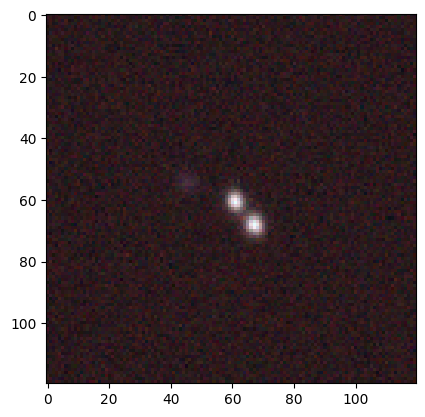

In [ ]:
from btk.plotting import get_rgb
rgb = get_rgb(im[bands])
plt.imshow(rgb)

# Deblending

The next big part of BTK is the deblending. We will use the `Deblender` class to deblend the images we just drew. By 'deblending' we mean that we want to recover the individual galaxies that were blended together in the images. This includes recovering their positions, fluxes, and shapes.

In this tutorial we will use the `SExtractor` deblender, which is implemented in the `btk.deblender` module. Specifically the class `SepSingleband` is a wrapper around the [SEP](https://sep.readthedocs.io/en/v1.1.x/) package, which is a python implementation of the [SExtractor](https://www.astromatic.net/software/sextractor) algorithm that performs detection on a single band.

Here is how we create the `Deblender` object:

In [ ]:
from btk.deblend import SepSingleBand

In [ ]:
deblender = SepSingleBand(sigma_noise=3, # threshold pixel value for detection (see SEP docs)
                          use_band=2 # measure on 'r' band
                          )

You can use the `Deblender` object to deblend the images we drew earlier. The `Deblender` object takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and/or catalogs.

In [ ]:
output = deblender.deblend(0, blend_batch) # deblend the first blend in the batch
output

DeblendExample(max_n_sources = 3, image_size = 120), containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: <class 'numpy.ndarray'>, shape [3, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [3, 120, 120]

Let's inspect the output which is a `DeblendedExample` object. The output contains at least a `catalog` attribute, which in this case contains the locations for the deblended objects in the first blend of the batch.

In [ ]:
print(output)

DeblendExample(max_n_sources = 3, image_size = 120), containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: <class 'numpy.ndarray'>, shape [3, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [3, 120, 120]


In [ ]:
output.catalog

ra,dec
float64,float64
0.31161884536051454,0.24041090156009715
1.509983675006985,1.7089094567701604


There is also an option to run the deblender on the full batch with the `__call__` method of any `Deblender` object. This method takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and catalogs for each blend in the batch.

In [ ]:
deblend_batch = deblender(blend_batch, njobs=1) # deblend the whole batch
deblend_batch

DeblendBatch(batch_size = 100, max_n_sources = 3, stamp_size = 120, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	segmentation: <class 'numpy.ndarray'>, shape [100, 3, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [100, 3, 120, 120]

You can access them as attributes of the `DeblenderBatch` object:

In [ ]:
deblend_batch.catalog_list[0] # predicted catalog for the first blend in the batch

ra,dec
float64,float64
0.31161884536051454,0.24041090156009715
1.509983675006985,1.7089094567701604


Let's compare the results from both the truth catalog and predicted catalog.

In [ ]:
wcs.all_world2pix

Object `wcs.all_world2pix` not found.


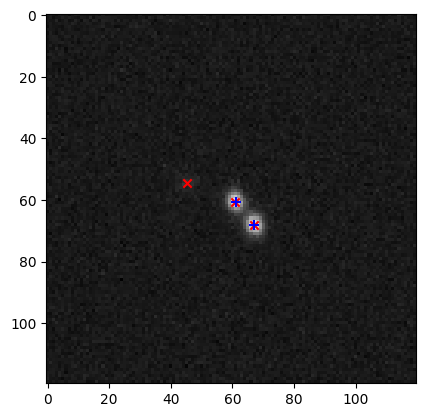

In [ ]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[0, 2, :, :], cmap="gray")

# plot centers of truth
plt.scatter(blend_batch.catalog_list[0]["x_peak"], blend_batch.catalog_list[0]["y_peak"], c="r", marker="x")

# plot centers of prediction

# need to use wcs to convert ra and dec to x and y
ra, dec = deblend_batch.catalog_list[0]["ra"], deblend_batch.catalog_list[0]["dec"]
x, y = blend_batch.wcs.world_to_pixel_values(ra / 3600, dec / 3600) # need to convert to arcseconds
plt.scatter(x, y, c="b", marker="+", s=50)

We can also inspect the deblended images and compare with the isolated ones.

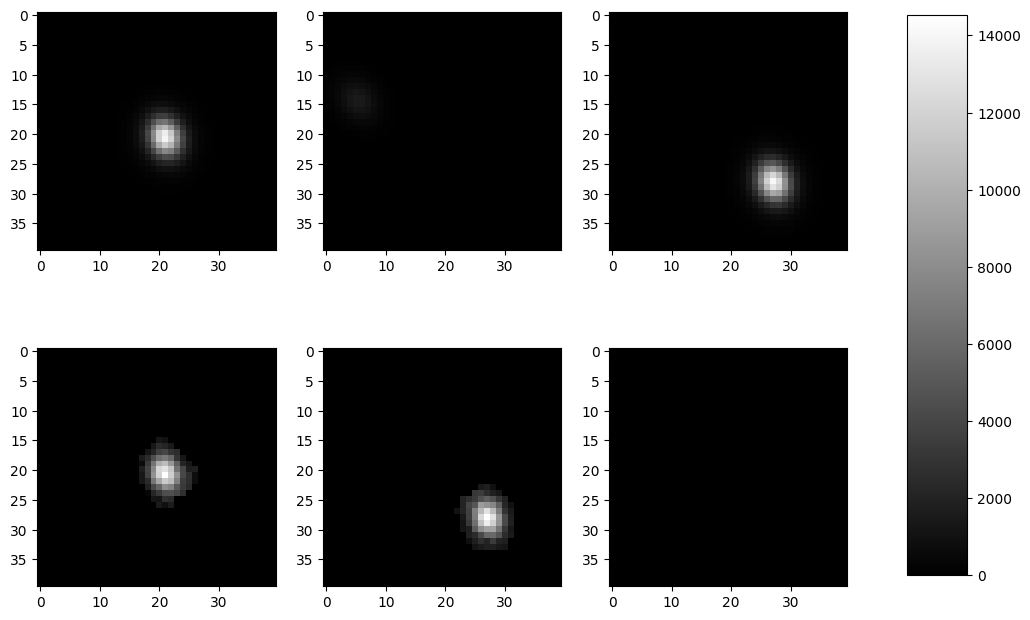

In [ ]:
# plot isolated images from truth 
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

true_images = blend_batch.isolated_images[0, :, 2, 40:80, 40:80]
pred_images = deblend_batch.deblended_images[0, :, 40:80, 40:80] # only contains r-band

# use global vmin and vmax
vmin = min(true_images.min(), pred_images.min())
vmax = max(true_images.max(), pred_images.max())

for ii in range(3):
    ax = axes.flatten()[ii]
    ax.imshow(blend_batch.isolated_images[0, ii, 2, 40:80, 40:80], cmap="gray", 
              vmin=vmin, vmax=vmax)

# plot isolated images from prediction
for ii in range(3, 6):
    ax = axes.flatten()[ii]
    ax.imshow(deblend_batch.deblended_images[0, ii-3, 40:80, 40:80], cmap="gray", 
              vmin=vmin, vmax=vmax)

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0, 0].imshow(blend_batch.isolated_images[0, 0, 2, 40:80, 40:80], cmap="gray", vmin=vmin, vmax=vmax), cax=cbar_ax)

We provide a convenient way to automate the process of deblending using the `DeblenderGenerator` class. This class is a python `generator`, meaning it can be called with `next(generator)` to generate a new batch of deblended images and catalogs. Internally, it also calls the `DrawBlendsGenerator` to draw new batches of images.

This class is useful if you want to deblend a large number of images, and you don't want to store them all in memory at the same time. It is also helpful if you want to pass in multiple deblender simultaneously and compare their performance.

In [ ]:
from btk.deblend import DeblenderGenerator

deblender_generator = DeblenderGenerator(deblender, draw_generator, cpus=1)
blend_batch, deblend_output = next(deblender_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

The output is a tuple, where the first entry is the `BlendBatch` directly from the `DrawBlendsGenerator`, and the second entry is a dictionary containing one key per `Deblender` passed with the output from the `batch_call` of the `Deblender` object (`DeblenderBatch`).

In [ ]:
deblend_output['SepSingleband']

MeasuredBatch(batch_size = 100, max_n_sources = 3, stamp_size = 24.0, survey_name = LSST), containing: 
	catalog: list of <class 'astropy.table.table.Table'>, size 100
	segmentation: np.ndarray, shape [100, 3, 120, 120]
	deblended_images: np.ndarray, shape [100, 3, 120, 120]

# Matching

# Metrics

TBD... 